# Registration Initialization: We Have to Start Somewhere

Initialization is a critical aspect of most registration algorithms, given that most algorithms are formulated as an iterative optimization problem. It effects both the runtime and convergence to the correct minimum. Ideally our transformation is initialized close to the correct solution ensuring convergence in a timely manner. Problem specific initialization will often yield better results than generic initialization approaches. 

**Rule of thumb**: use as much prior information (external to the image content) as you can to initialize your registration.

Common initializations strategies when no prior information is available:
1. Do nothing (hope springs eternal) - initialize using the identity transformation.
2. CenteredTransformInitializer (GEOMETRY or MOMENTS) - translation based initialization, align the geometric centers of the images or the intensity based centers of mass of the image contents.
3. Use a sampling of the parameter space (useful mostly for low dimensional parameter spaces).
4. Manual initialization - allow an operator to control transformation parameter settings directly using a GUI with visual feedback or identify multiple corresponding points in the two images and compute an initial rigid or affine transformation. 


In many cases we perform initialization in an automatic manner by making assumptions with regard to the contents of the image and the imaging protocol. For instance, if we expect that images were acquired with the patient in a known orientation we can align the geometric centers of the two volumes or the center of mass of the image contents if the anatomy is not centered in the image (this is what we previously did in [this example](60_Registration_Introduction.ipynb)).

When the orientation is not known, or is known but incorrect, this approach will not yield a reasonable initial estimate for the registration.

When working with clinical images, the DICOM tags define the orientation and position of the anatomy in the volume. The tags of interest are:
<ul>
  <li> (0020|0032) Image Position (Patient) : coordinates of the the first transmitted voxel. </li>
  <li>(0020|0037) Image Orientation (Patient): directions of first row and column in 3D space. </li>
  <li>(0018|5100) Patient Position: Patient placement on the table 
  <ul>
  <li> Head First Prone (HFP)</li>
  <li> Head First Supine (HFS)</li>
  <li> Head First Decubitus Right (HFDR)</li>
  <li> Head First Decubitus Left (HFDL)</li>
  <li> Feet First Prone (FFP)</li>
  <li> Feet First Supine (FFS)</li>
  <li> Feet First Decubitus Right (FFDR)</li>
  <li> Feet First Decubitus Left (FFDL)</li>
  </ul>
  </li>
</ul>

The patient position is manually entered by the CT/MR operator and thus can be erroneous (HFP instead of FFP will result in a $180^o$ orientation error). In this notebook we use data acquired using an abdominal phantom which made it hard to identify the "head" and "feet" side, resulting in an incorrect value entered by the technician. 

In [11]:
import SimpleITK as sitk

# If the environment variable SIMPLE_ITK_MEMORY_CONSTRAINED_ENVIRONMENT is set, this will override the ReadImage
# function so that it also resamples the image to a smaller size (testing environment is memory constrained).
%run setup_for_testing

import os
import numpy as np

from ipywidgets import interact, fixed

%run update_path_to_download_script
from downloaddata import fetch_data as fdata

%matplotlib notebook
import gui


# This is the registration configuration which we use in all cases. The only parameter that we vary
# is the initial_transform.
def multires_registration(fixed_image, moving_image, initial_transform):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=100,
        estimateLearningRate=registration_method.Once,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    final_transform = registration_method.Execute(fixed_image, moving_image)
    print(f"Final metric value: {registration_method.GetMetricValue()}")
    print(
        f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
    )
    return (final_transform, registration_method.GetMetricValue())

<Figure size 640x480 with 0 Axes>

## Loading Data

**Note**: While the images are of the same phantom, they were acquired at different times and the fiducial markers visible on the phantom are not in the same locations.

Scroll through the data to gain an understanding of the spatial relationship along the viewing (z) axis.

In [12]:
%matplotlib widget

data_directory = os.path.dirname(fdata("CIRS057A_MR_CT_DICOM/readme.txt"))

fixed_series_ID = "1.2.840.113619.2.290.3.3233817346.783.1399004564.515"
moving_series_ID = "1.3.12.2.1107.5.2.18.41548.30000014030519285935000000933"

reader = sitk.ImageSeriesReader()
fixed_image = sitk.ReadImage(
    reader.GetGDCMSeriesFileNames(data_directory, fixed_series_ID), sitk.sitkFloat32
)
moving_image = sitk.ReadImage(
    reader.GetGDCMSeriesFileNames(data_directory, moving_series_ID), sitk.sitkFloat32
)

# To provide a reasonable display we need to window/level the images. By default we could have used the intensity
# ranges found in the images [SimpleITK's StatisticsImageFilter], but these are not the best values for viewing.
# Try using the full intensity range in the GUI to see that it is not a good choice for visualization.
ct_window_level = [932, 180]
mr_window_level = [286, 143]

gui.MultiImageDisplay(
    image_list=[fixed_image, moving_image],
    title_list=["fixed image", "moving image"],
    figure_size=(8, 4),
    window_level_list=[ct_window_level, mr_window_level],
    intensity_slider_range_percentile=[0, 100],
);

Fetching CIRS057A_MR_CT_DICOM/readme.txt


<IPython.core.display.Javascript object>

## Register using centered transform initializer  (assumes orientation is similar)

In [3]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

final_transform, _ = multires_registration(fixed_image, moving_image, initial_transform)

Final metric value: -0.4425155300256447
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 13.


Visually evaluate the results using a linked cursor approach, a mouse click in one image will create the "corresponding" point in the other image. Don't be fooled by clicking on the "ribs" (symmetry is the bane of registration).

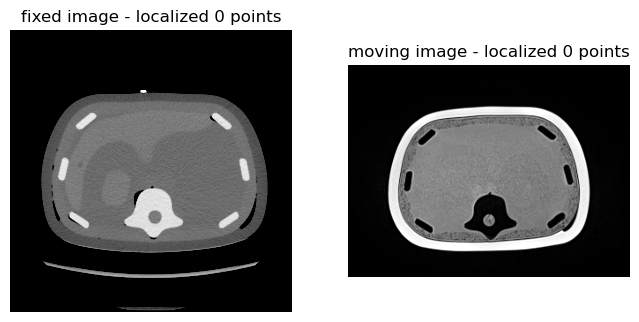

In [5]:
gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    known_transformation=final_transform,
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);

## Register using sampling of the parameter space

As we want to account for significant orientation differences due to erroneous patient position (HFS...) we evaluate the similarity measure at locations corresponding to the various orientation differences. This can be done in two ways which will be illustrated below:
<ul>
<li>Use the ImageRegistrationMethod.MetricEvaluate() method.</li>
<li>Use the Exhaustive optimizer.
</ul>

The former approach is more computationally intensive as it constructs and configures a metric object each time it is invoked. It is therefore more appropriate for use if the set of parameter values we want to evaluate are not on a rectilinear grid in the parameter space. The latter approach is appropriate if the set of parameter values are on a rectilinear grid, in which case the approach is more computationally efficient.

In both cases we use the CenteredTransformInitializer to obtain the initial translation.

### MetricEvaluate

To use the MetricEvaluate method we create a ImageRegistrationMethod, set its metric and interpolator. We then iterate over all parameter settings, set the initial transform and evaluate the metric. The minimal similarity measure value corresponds to the best parameter settings.

In [ ]:
# Dictionary with all the orientations we will try. We omit the identity (x=0, y=0, z=0) as we always use it. This
# set of rotations is arbitrary. For a complete grid coverage we would naively have 64 entries
# (0, pi/2, pi, 1.5pi for each angle), but we know better, there are only 24 unique rotation matrices defined by
# these parameter value combinations.
all_orientations = {
    "x=0, y=0, z=180": (0.0, 0.0, np.pi),
    "x=0, y=180, z=0": (0.0, np.pi, 0.0),
    "x=0, y=180, z=180": (0.0, np.pi, np.pi),
}

# Registration framework setup.
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkLinear)

# Evaluate the similarity metric using the rotation parameter space sampling, translation remains the same for all.
initial_transform = sitk.Euler3DTransform(
    sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY,
    )
)
registration_method.SetInitialTransform(initial_transform, inPlace=False)
best_orientation = (0.0, 0.0, 0.0)
best_similarity_value = registration_method.MetricEvaluate(fixed_image, moving_image)

# Iterate over all other rotation parameter settings.
for key, orientation in all_orientations.items():
    initial_transform.SetRotation(*orientation)
    registration_method.SetInitialTransform(initial_transform)
    current_similarity_value = registration_method.MetricEvaluate(
        fixed_image, moving_image
    )
    if current_similarity_value < best_similarity_value:
        best_similarity_value = current_similarity_value
        best_orientation = orientation
print("best orientation is: " + str(best_orientation))

#### Why loop if you can process in parallel
As the metric evaluations are independent of each other, we can easily replace looping with parallelization. 

In [ ]:
from multiprocessing.pool import ThreadPool
from functools import partial


# This function evaluates the metric value in a thread safe manner
def evaluate_metric(current_rotation, tx, f_image, m_image):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    current_transform = sitk.Euler3DTransform(tx)
    current_transform.SetRotation(*current_rotation)
    registration_method.SetInitialTransform(current_transform)
    res = registration_method.MetricEvaluate(f_image, m_image)
    return res


p = ThreadPool(len(all_orientations) + 1)
orientations_list = [(0, 0, 0)] + list(all_orientations.values())
all_metric_values = p.map(
    partial(
        evaluate_metric, tx=initial_transform, f_image=fixed_image, m_image=moving_image
    ),
    orientations_list,
)
best_orientation = orientations_list[np.argmin(all_metric_values)]
print("best orientation is: " + str(best_orientation))

In [ ]:
initial_transform.SetRotation(*best_orientation)
final_transform, _ = multires_registration(fixed_image, moving_image, initial_transform)

Visually evaluate the registration results:

In [ ]:
gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    known_transformation=final_transform,
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);

### Exhaustive optimizer

The exhaustive optimizer evaluates the similarity metric on a grid in parameter space centered on the parameters of the initial transform. This grid is defined using three elements:
1. numberOfSteps.
2. stepLength.
3. optimizer scales.

The similarity metric is evaluated on the resulting parameter grid:
initial_parameters &plusmn; numberOfSteps &times; stepLength &times; optimizerScales

***Example***:
1. numberOfSteps=[1,0,2,0,0,0]
2. stepLength = np.pi
3. optimizer scales = [1,1,0.5,1,1,1]

Will perform 15 metric evaluations ($\displaystyle\prod_i (2*numberOfSteps[i] + 1)$).

The parameter values for the second parameter and the last three parameters are the initial parameter values. The parameter values for the first parameter are $v_{init}-\pi, v_{init}, v_{init}+\pi$ and the parameter values for the third parameter are $v_{init}-\pi, v_{init}-\pi/2, v_{init}, v_{init}+\pi/2, v_{init}+\pi$.

The transformation corresponding to the lowest similarity metric is returned.

Using this approach we have superfluous evaluations, due to the symmetry of the grid in parameter space. On the other hand this method is often faster than evaluating the metric using the `MetricEvaluate` method (due to the setup and tear down time).  

In [13]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkLinear)
# The order of parameters for the Euler3DTransform is [angle_x, angle_y, angle_z, t_x, t_y, t_z]. The parameter
# sampling grid is centered on the initial_transform parameter values, that are all zero for the rotations. Given
# the number of steps and their length and optimizer scales we have:
# angle_x = 0
# angle_y = -pi, 0, pi
# angle_z = -pi, 0, pi
registration_method.SetOptimizerAsExhaustive(
    numberOfSteps=[0, 1, 1, 0, 0, 0], stepLength=np.pi
)
registration_method.SetOptimizerScales([1, 1, 1, 1, 1, 1])

# Perform the registration in-place so that the initial_transform is modified.
registration_method.SetInitialTransform(initial_transform, inPlace=True)
registration_method.Execute(fixed_image, moving_image)

print("best initial transformation is: " + str(initial_transform.GetParameters()))

best initial transformation is: (0.0, -3.141592653589793, 0.0, 20.001234054570006, 29.082113265990003, 83.84380323625999)


Run the registration and visually evaluate the results:

In [14]:
final_transform, _ = multires_registration(fixed_image, moving_image, initial_transform)
gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    known_transformation=final_transform,
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);

Final metric value: -0.5295081738985897
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 12.


<IPython.core.display.Javascript object>

### Exhaustive optimizer - an exploration-exploitation view

In the example above we used the exhaustive optimizer to obtain an initial value for our transformation parameter values. This approach has two limitations:
1. It assumes we only want to sample the parameter space using a continuous regular grid. This is not appropriate if we want to explore multiple discontinuous regions of the parameter space (e.g. tx = [0.5, 1.0, 1.5] and tx = [ 12.0, 12.5, 13.0] and...).
2. It assumes that the parameter values corresponding to the best metric value from our sample will enable convergence to the desired optimum. To quote [George Gershwin](https://en.wikipedia.org/wiki/George_Gershwin) - "It Ain't Necessarily So". 

If we consider the exhaustive optimizer in the context of the exploration-exploitation heuristic framework, we first search the parameter space for promising solution(s) and then refine the solution(s), we can readily address these limitations:

1. Explore multiple discontinuous regions using a single or multiple instances of the ExhaustiveOptimizer or use the MetricEvaluate approach if the samples do not define a regular grid.
2. Obtain *all* of the parameter space samples and exploit (run final registration) for each of the k most promising solutions.

Below we implement the latter: (a) We explore the parameter space using the exhaustive optimizer's callback mechanism to obtain all of the parameter values and their corresponding metric values. (b) We exploit the k_most_promising parameter values to obtain the final transformation.

**NOTE**: This is a heuristic and only increases the probability of convergence to the desired optimum. In some cases this approach may be detrimental when the parameter values we seek correspond to a local optimum and not a global one.

In [15]:
#
# Exploration step.
#
def start_observer():
    global metricvalue_parameters_list
    metricvalue_parameters_list = []


def iteration_observer(registration_method):
    metricvalue_parameters_list.append(
        (
            registration_method.GetMetricValue(),
            registration_method.GetOptimizerPosition(),
        )
    )


initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkLinear)
# The order of parameters for the Euler3DTransform is [angle_x, angle_y, angle_z, t_x, t_y, t_z]. The parameter
# sampling grid is centered on the initial_transform parameter values, that are all zero for the rotations. Given
# the number of steps and their length and optimizer scales we have:
# angle_x = 0
# angle_y = -pi, 0, pi
# angle_z = -pi, 0, pi
registration_method.SetOptimizerAsExhaustive(
    numberOfSteps=[0, 1, 1, 0, 0, 0], stepLength=np.pi
)
registration_method.SetOptimizerScales([1, 1, 1, 1, 1, 1])

# We don't really care if transformation is modified in place or not, we will select the k
# best transformations from the parameters_metricvalue_list.
registration_method.SetInitialTransform(initial_transform, inPlace=True)

registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: iteration_observer(registration_method)
)
registration_method.AddCommand(sitk.sitkStartEvent, start_observer)
_ = registration_method.Execute(fixed_image, moving_image)

In [16]:
#
# Exploitation step.
#

# Sort our list from most to least promising solutions (low to high metric values).
metricvalue_parameters_list.sort(key=lambda x: x[0])

# We exploit the k_most_promising parameter value settings.
k_most_promising = min(3, len(metricvalue_parameters_list))
final_results = []
for metricvalue, parameters in metricvalue_parameters_list[0:k_most_promising]:
    initial_transform.SetParameters(parameters)
    final_results.append(
        multires_registration(fixed_image, moving_image, initial_transform)
    )

final_transform, _ = min(final_results, key=lambda x: x[1])
gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    known_transformation=final_transform,
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);

Final metric value: -0.5137134232802376
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
Final metric value: -0.501149337962652
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
Final metric value: -0.37506163467782977
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


<IPython.core.display.Javascript object>

## Register using manual initialization

When all else fails, a human in the loop will almost always be able to robustly initialize the registration.

In the example below we identify corresponding points to compute an initial rigid transformation. You will need to click on corresponding points in each of the images, going back and forth between them. The interface will "force" you to create point pairs (you will not be able to add multiple points in one image). 

**Note**: 
1. There is no correspondence between the fiducial markers on the phantom.
2. After localizing points in the GUI below, comment out the hard-coded point data, two cells below, which is there FOR TESTING.

In [ ]:
point_acquisition_interface = gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);

In [ ]:
# Get the manually specified points and compute the transformation.
fixed_image_points, moving_image_points = point_acquisition_interface.get_points()

# FOR TESTING: previously localized points
fixed_image_points = [
    (24.062587103074605, 14.594981536981521, -58.75),
    (6.178716135332678, 53.93949766601378, -58.75),
    (74.14383149714774, -69.04462737237648, -76.25),
    (109.74899278747029, -14.905272533666817, -76.25),
]
moving_image_points = [
    (4.358707846364581, 60.46357110706131, -71.53120422363281),
    (24.09010295252645, 98.21840981673873, -71.53120422363281),
    (-52.11888008581127, -26.57984635768439, -58.53120422363281),
    (-87.46150681392184, 28.73904765153219, -58.53120422363281),
]

fixed_image_points_flat = [c for p in fixed_image_points for c in p]
moving_image_points_flat = [c for p in moving_image_points for c in p]
init_transform = sitk.VersorRigid3DTransform(
    sitk.LandmarkBasedTransformInitializer(
        sitk.VersorRigid3DTransform(), fixed_image_points_flat, moving_image_points_flat
    )
)
# Convert from Versor to Euler, as Versor does not always work well with the optimization.
# Internally the optimization sets new parameter values without any constraints, and the versor
# normalizes its vector component if it is greater than 1-epsilon.
initial_transform = sitk.Euler3DTransform()
initial_transform.SetCenter(init_transform.GetCenter())
initial_transform.SetMatrix(init_transform.GetMatrix())
initial_transform.SetTranslation(init_transform.GetTranslation())
print("manual initial transformation is: " + str(initial_transform.GetParameters()))

Run the registration and visually evaluate the results:

In [ ]:
final_transform, _ = multires_registration(fixed_image, moving_image, initial_transform)
gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    known_transformation=final_transform,
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);

## Register using manual initialization - slice to volume

In some cases, initialization may be more critical than others. For example, when registering a 2D slice to a 3D image. This requires careful initialization because the potential for converging to a local minimum is much larger than when we register two corresponding volumes. Note that SimpleITK does not support 2D/3D registration. A slice to volume registration is a 3D/3D registration. The slice is a "very thin" 3D image, one of the axes has a size of one.

In the next cells we explore the basic slice to volume registration scenario.

In [ ]:
fixed_image_slice = fixed_image[
    :, :, fixed_image.GetDepth() // 2 : fixed_image.GetDepth() // 2 + 1
]
# We know our image is rotated by 180 degrees around the y axis, and the rotation center
# should be the center of the image.
fixed_image_center = fixed_image_slice.TransformContinuousIndexToPhysicalPoint(
    [(sz - 1) / 2 for sz in fixed_image_slice.GetSize()]
)
initial_transform = sitk.Euler3DTransform(fixed_image_center, 0, 3.141592653589793, 0)

Find an initial translation for the image by scrolling through the moving image volume.

In [ ]:
slice_index_interface = gui.MultiImageDisplay(
    [fixed_image_slice, moving_image],
    title_list=["fixed image", "moving image"],
    figure_size=(8, 4),
    window_level_list=[ct_window_level, mr_window_level],
    intensity_slider_range_percentile=[0, 100],
);

In [ ]:
# Align the center of the fixed image slice to the center of the user selected moving image slice
selected_slice_index = slice_index_interface.slider_list[1].value
# FOR TESTING: next line sets a value for the selected slice, comment out when you actually want to work.
selected_slice_index = moving_image.GetDepth() // 2
moving_image_slice_center = moving_image.TransformContinuousIndexToPhysicalPoint(
    [
        (moving_image.GetWidth() - 1) / 2,
        (moving_image.GetHeight() - 1) / 2,
        selected_slice_index,
    ]
)
initial_transform.SetTranslation(
    [m - f for m, f in zip(moving_image_slice_center, fixed_image_center)]
)

gui.RegistrationPointDataAquisition(
    fixed_image_slice,
    moving_image,
    figure_size=(8, 4),
    known_transformation=initial_transform,
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);

Now that we have our initial transformation, mapping the slice to volume, we can run the final registration step. As we utilize multi-resolution registration, it includes image smoothing when creating the pyramid. This will cause the [SmoothingRecursiveGaussianImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1SmoothingRecursiveGaussianImageFilter.html) to throw an exception as it expects images to have at least four pixels in each dimension and we only have one pixel in the z axis. In the code below we remedy this by expanding our image in the z-direction using the [ExpandImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ExpandImageFilter.html#details). This filter utilizes interpolation to increase the image's pixel count while maintaining its spatial extent. This means that when we increase the number of pixels the spacing between them will decrease. As a reminder, an image's physical region extends 0.5*spacing beyond the first and last pixel locations. 

In [ ]:
expanded_fixed_image_slice = sitk.Expand(fixed_image_slice, [1, 1, 4], sitk.sitkLinear)

# Don't trust us, confirm that the expanded_fixed_image_slice and fixed_image_slice occupy the same
# region in physical space.

final_transform, _ = multires_registration(
    expanded_fixed_image_slice, moving_image, initial_transform
)
gui.RegistrationPointDataAquisition(
    fixed_image_slice,
    moving_image,
    figure_size=(8, 4),
    known_transformation=final_transform,
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);